In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pygmt
from datetime import datetime, timezone

In [2]:
datadir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/feature_splits'
p_train = pd.read_csv(os.path.join(datadir, 'p.train.csv'))
s_train = pd.read_csv(os.path.join(datadir, 's.train.csv'))
p_stats = pd.read_csv(os.path.join(datadir, 'p.station.ex.counts.csv'))
s_stats = pd.read_csv(os.path.join(datadir, 's.station.ex.counts.csv'))
stat_df = pd.read_csv('../data/catalogs/stat.info.csv')

In [3]:
def time_filter(cat_df, start_datetime, end_datetime, ot_col_name):
    return cat_df[(cat_df[ot_col_name] >= start_datetime.timestamp()) & 
                    (cat_df[ot_col_name] <= end_datetime.timestamp())]

catdir = '../data/catalogs'
ev_cat = pd.read_csv(f'{catdir}/yellowstone.events.2023.csv')
startdate = datetime(2012, 10, 1, tzinfo=timezone.utc)
enddate = datetime(2022, 7, 28, tzinfo=timezone.utc)
print(f"Filter ev catalog from {startdate} to {enddate} for consistency")
ev_cat_filt = time_filter(ev_cat, startdate, enddate, 'origin_time')


Filter ev catalog from 2012-10-01 00:00:00+00:00 to 2022-07-28 00:00:00+00:00 for consistency


In [4]:
station_df = pd.read_csv(os.path.join(catdir, 'stat.info.csv'))
arr_cat = pd.read_csv(os.path.join(catdir, 'yellowstone.arrivals.2023.csv'))

In [5]:
# Filter stations to those used kept for training and merge the station location information
p_stats = p_stats[p_stats['station'].isin(p_train['station'].unique())].merge(stat_df, on='station', how='left')
s_stats = s_stats[s_stats['station'].isin(s_train['station'].unique())].merge(stat_df, on='station', how='left')
print(p_stats.shape[0], s_stats.shape[0])
p_stats.head()

34 17


,station,cnt_train,cnt_test,network,receiver_lat,receiver_lon
0,YNR,4009.0,1008,WY,44.71550,-110.67917
1,YHH,4005.0,1002,WY,44.78833,-110.85050
2,YMC,3553.0,898,WY,44.75933,-111.00616
3,YMR,3393.0,845,WY,44.66867,-110.96500
4,YPM,3358.0,843,WY,44.65717,-110.86867


In [6]:
p_train.columns

Index(['arrival_identifier', 'avg_noise_1.00', 'avg_noise_10.00',
       'avg_noise_11.00', 'avg_noise_12.00', 'avg_noise_13.00',
       'avg_noise_14.00', 'avg_noise_15.00', 'avg_noise_16.00',
       'avg_noise_17.00', 'avg_noise_18.00', 'avg_noise_2.00',
       'avg_noise_3.00', 'avg_noise_4.00', 'avg_noise_5.00', 'avg_noise_6.00',
       'avg_noise_7.00', 'avg_noise_8.00', 'avg_noise_9.00', 'avg_signal_1.00',
       'avg_signal_10.00', 'avg_signal_11.00', 'avg_signal_12.00',
       'avg_signal_13.00', 'avg_signal_14.00', 'avg_signal_15.00',
       'avg_signal_16.00', 'avg_signal_17.00', 'avg_signal_18.00',
       'avg_signal_2.00', 'avg_signal_3.00', 'avg_signal_4.00',
       'avg_signal_5.00', 'avg_signal_6.00', 'avg_signal_7.00',
       'avg_signal_8.00', 'avg_signal_9.00', 'channel', 'event_identifier',
       'location_code', 'magnitude', 'magnitude_type', 'network',
       'noise_dominant_amplitude', 'noise_dominant_frequency',
       'noise_maximum_value', 'noise_minimum_value

In [7]:
p_train_ev = p_train[['event_identifier', 'source_latitude', 'source_longitude', 'source_depth_km']].drop_duplicates('event_identifier')
s_train_ev = s_train[['event_identifier', 'source_latitude', 'source_longitude', 'source_depth_km']].drop_duplicates('event_identifier')
print(p_train_ev.shape[0], s_train_ev.shape[0])

5131 4412


In [8]:
# Read in park and caldera boundaries
utahnet_path = '../data/utahnet'
ys_border = pd.read_csv(f"{utahnet_path}/yell.border.g", delimiter=" ", names=["Longitude", "Latitude"], dtype=np.float64)
caldera = pd.read_csv(f"{utahnet_path}/caldera.ys", sep="\s+", names=["Latitude", "Longitude"], dtype=np.float64)

caldera = caldera.drop(caldera[caldera["Longitude"]==0].index)
caldera = caldera[["Longitude", "Latitude"]]
caldera["Longitude"] = caldera["Longitude"]*-1
caldera.head()

,Longitude,Latitude
0,-110.6149,44.7057
1,-110.6154,44.7040
2,-110.6158,44.7023
3,-110.6162,44.7003
4,-110.6158,44.6986


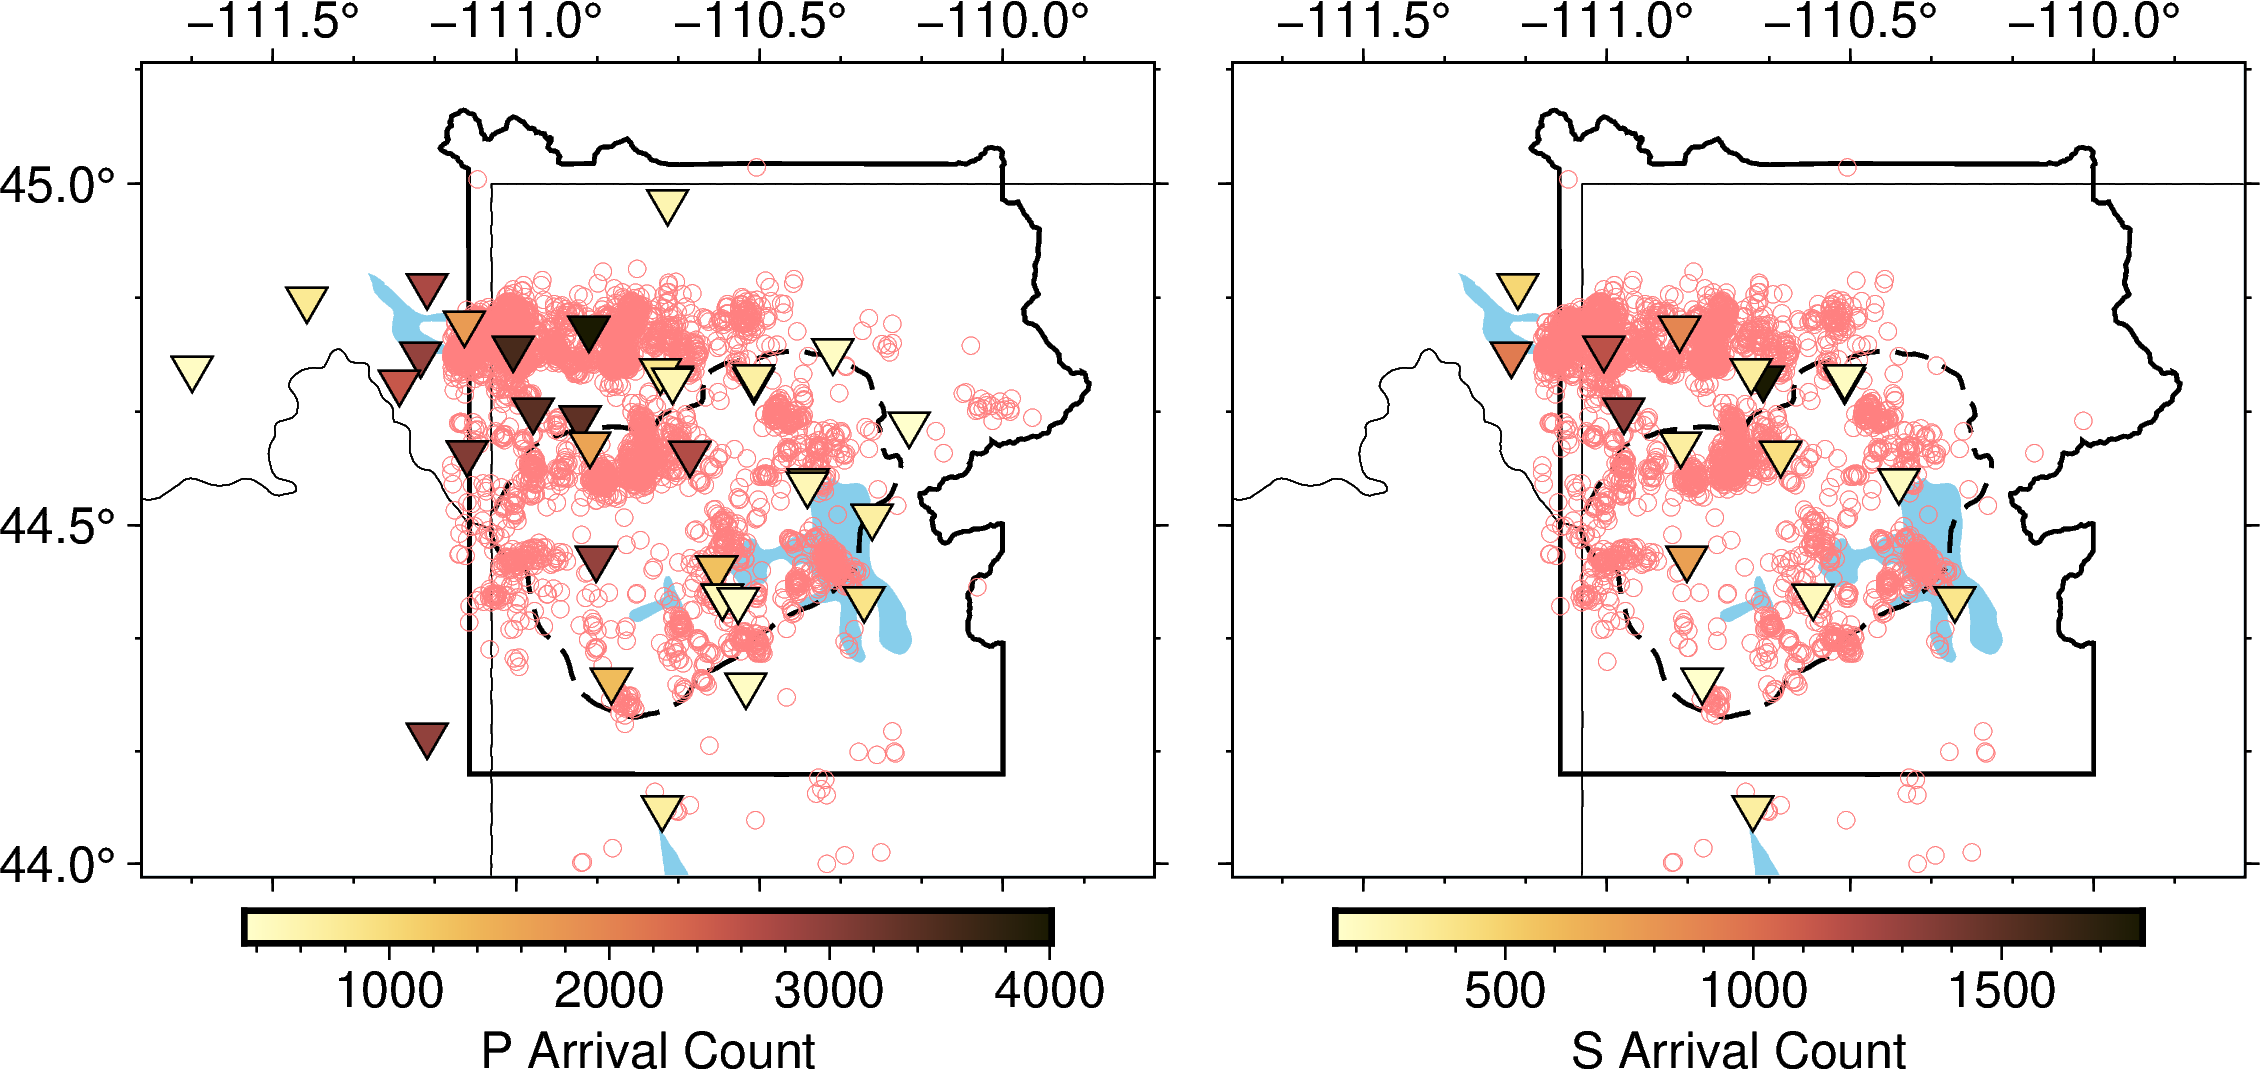

In [9]:
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP="ddd.x", MAP_FRAME_TYPE="plain", FONT='12p', FONT_ANNOT_PRIMARY='12p')

region = [
    p_stats.receiver_lon.min() - 0.1,
    p_stats.receiver_lon.max() + 0.5,
    p_stats.receiver_lat.min() - 0.1,
    p_stats.receiver_lat.max() + 0.2,
]

with fig.subplot(ncols=2, figsize=("7i", "4i"), sharey='l', sharex='t'):
    with fig.set_panel(panel=0):  # sets the current panel
        fig.basemap(region=region, projection="M?")
        fig.coast(land="white", borders=2, water="skyblue")
        pygmt.makecpt(cmap="lajolla", series=[p_stats.cnt_train.min(), p_stats.cnt_train.max()])
        fig.plot(data=ys_border, pen="1.0p,black")
        fig.plot(data=caldera, pen='1.0p,black,--')

        #fig.plot(data=p_train_ev[["source_longitude", "source_latitude"]], style="c0.15c", pen="0.1p,darkgray")
        fig.plot(data=p_train_ev[["source_longitude", "source_latitude"]], style="c0.15c", pen="0.1p,lightred")

        fig.plot(x=p_stats.receiver_lon, y=p_stats.receiver_lat,
        style="i0.4c", fill=p_stats.cnt_train, cmap=True, pen="0.5p,black")

        fig.colorbar(frame='af+l"P Arrival Count"')
    with fig.set_panel(panel=1):  # sets the current panel
        fig.basemap(region=region, projection="M?")
        fig.coast(land="white", borders=2, water="skyblue")

        pygmt.makecpt(cmap="lajolla", series=[s_stats.cnt_train.min(), s_stats.cnt_train.max()])
        fig.plot(data=ys_border, pen="1.0p,black")
        fig.plot(data=caldera, pen='1.0p,black,--')

        #fig.plot(data=s_train_ev[["source_longitude", "source_latitude"]], style="c0.15c", pen="0.1p,darkgray")
        fig.plot(data=s_train_ev[["source_longitude", "source_latitude"]], style="c0.15c", pen="0.1p,lightred")

        fig.plot(x=s_stats.receiver_lon, y=s_stats.receiver_lat,
                 style="i0.4c", fill=s_stats.cnt_train, cmap=True, pen="0.5p,black")

        fig.colorbar(frame='af+l"S Arrival Count"') # @%Times-Italic%
fig.show()
# fig.savefig('side_by_side_station_counts.png', dpi=300)

In [10]:
ps_merge_ev = p_train_ev.merge(s_train_ev, how='outer', on='event_identifier', indicator=True, suffixes=('_p', '_s'))
ps_merge_ev.head()

,event_identifier,source_latitude_p,source_longitude_p,source_depth_km_p,source_latitude_s,source_longitude_s,source_depth_km_s,_merge
0,60000622,44.764500,-111.088000,7.69,44.764500,-111.088000,7.69,both
1,60001352,44.389333,-111.035833,14.30,44.389333,-111.035833,14.30,both
2,60001367,44.406333,-111.053833,10.32,44.406333,-111.053833,10.32,both
3,60001387,44.399000,-111.044500,15.82,44.399000,-111.044500,15.82,both
4,60001392,44.393667,-111.051833,15.91,NaN,NaN,NaN,left_only


In [11]:
ps_merge_ev[ps_merge_ev['_merge'] == 'right_only']

,event_identifier,source_latitude_p,source_longitude_p,source_depth_km_p,source_latitude_s,source_longitude_s,source_depth_km_s,_merge
5131,60376027,NaN,NaN,NaN,44.777667,-111.125667,7.89,right_only


In [12]:
ev_cat_filt[ev_cat_filt['evid'] == 60376027]

,evid,event_lat,event_lon,event_depth,origin_time,magnitude,magnitude_type,rflag,utc
13476,60376027,44.777667,-111.125667,7.89,1.586276e+09,0.88,l,F,2020-04-07 16:11:42.040001+00:00


In [13]:
ev_cat_filt[ev_cat_filt['magnitude_type'] == 'l'][~ev_cat_filt[ev_cat_filt['magnitude_type'] == 'l']['evid'].isin(ps_merge_ev['event_identifier'])]

,evid,event_lat,event_lon,event_depth,origin_time,magnitude,magnitude_type,rflag,utc
46,60000620,44.474500,-110.552667,4.43,1.357546e+09,2.19,l,F,2013-01-07 08:12:32.649998+00:00
64,60000940,44.479000,-110.591167,2.20,1.362430e+09,1.12,l,F,2013-03-04 20:50:17.969999+00:00
65,60000950,44.473500,-110.573333,-2.76,1.362431e+09,2.04,l,F,2013-03-04 21:02:42.149998+00:00
66,60000955,44.471833,-110.571000,4.69,1.362431e+09,2.06,l,F,2013-03-04 21:02:56.459999+00:00
73,60001055,44.323667,-110.683333,5.11,1.366107e+09,1.37,l,F,2013-04-16 10:03:41.809998+00:00
...,...,...,...,...,...,...,...,...,...
17282,60506367,44.820167,-110.973167,4.95,1.658272e+09,0.76,l,F,2022-07-19 23:01:29.619999+00:00
17283,60506652,44.788833,-110.808667,5.60,1.658446e+09,0.99,l,F,2022-07-21 23:34:38.889999+00:00
17284,60506702,44.795167,-110.950167,6.34,1.658500e+09,1.02,l,F,2022-07-22 14:23:08.429999+00:00
17286,60506742,44.686500,-110.700333,8.01,1.658511e+09,1.65,l,F,2022-07-22 17:32:47.059998+00:00


In [14]:
ps_merge_stats = p_stats.merge(s_stats, on='station',how='outer',indicator=True, suffixes=('_p', '_s') )

In [15]:
ps_merge_stats[ps_merge_stats['_merge']=='both']#[['receiver_lon_p', 'receiver_lat_p']]

,station,cnt_train_p,cnt_test_p,network_p,receiver_lat_p,receiver_lon_p,cnt_train_s,cnt_test_s,network_s,receiver_lat_s,receiver_lon_s,_merge
0,YNR,4009.0,1008,WY,44.715500,-110.679170,1784.0,454.0,WY,44.715500,-110.679170,both
1,YHH,4005.0,1002,WY,44.788330,-110.850500,883.0,214.0,WY,44.788330,-110.850500,both
2,YMC,3553.0,898,WY,44.759330,-111.006160,1157.0,306.0,WY,44.759330,-111.006160,both
3,YMR,3393.0,845,WY,44.668670,-110.965000,1293.0,303.0,WY,44.668670,-110.965000,both
7,YHB,2920.0,734,WY,44.750800,-111.196200,942.0,227.0,WY,44.750800,-111.196200,both
8,YFT,2915.0,723,WY,44.451330,-110.835830,741.0,188.0,WY,44.451330,-110.835830,both
9,YHL,2739.0,682,WY,44.850900,-111.183000,468.0,114.0,WY,44.850900,-111.183000,both
10,YML,2678.0,638,WY,44.605330,-110.643170,421.0,107.0,WY,44.605330,-110.643170,both
13,B207,1609.0,380,PB,44.619000,-110.848500,314.0,81.0,PB,44.619000,-110.848500,both
14,YUF,1433.0,351,WY,44.712600,-110.511700,725.0,190.0,WY,44.712600,-110.511700,both


In [16]:
stats_with_corrections = ['BUT', 'AHID', 'BOZ', 'BW06', 'LKWY', 'YFT', 'YHB', 'YMR', 'YNR', 'YUF']
james_stat_corrections = ['LOHW', 'REDW', 'YEE', 'YHH', 'YHL', 'YHR', 'YMP', 'YNE', 'YPP', 'YTP']

In [17]:
station_df['station'].isin(stats_with_corrections)*1

0     1
1     0
2     0
3     1
4     0
     ..
62    0
63    0
64    0
65    0
66    0
Name: station, Length: 67, dtype: int64

In [18]:
station_df[station_df['network'] == 'PB']

,network,station,receiver_lat,receiver_lon
4,PB,B207,44.6190,-110.8485
9,PB,B944,44.3897,-110.5438
12,PB,B208,44.5602,-110.4015
20,PB,B206,44.7177,-110.5117
34,PB,B945,44.8940,-110.7441
47,PB,B950,44.7128,-110.6785


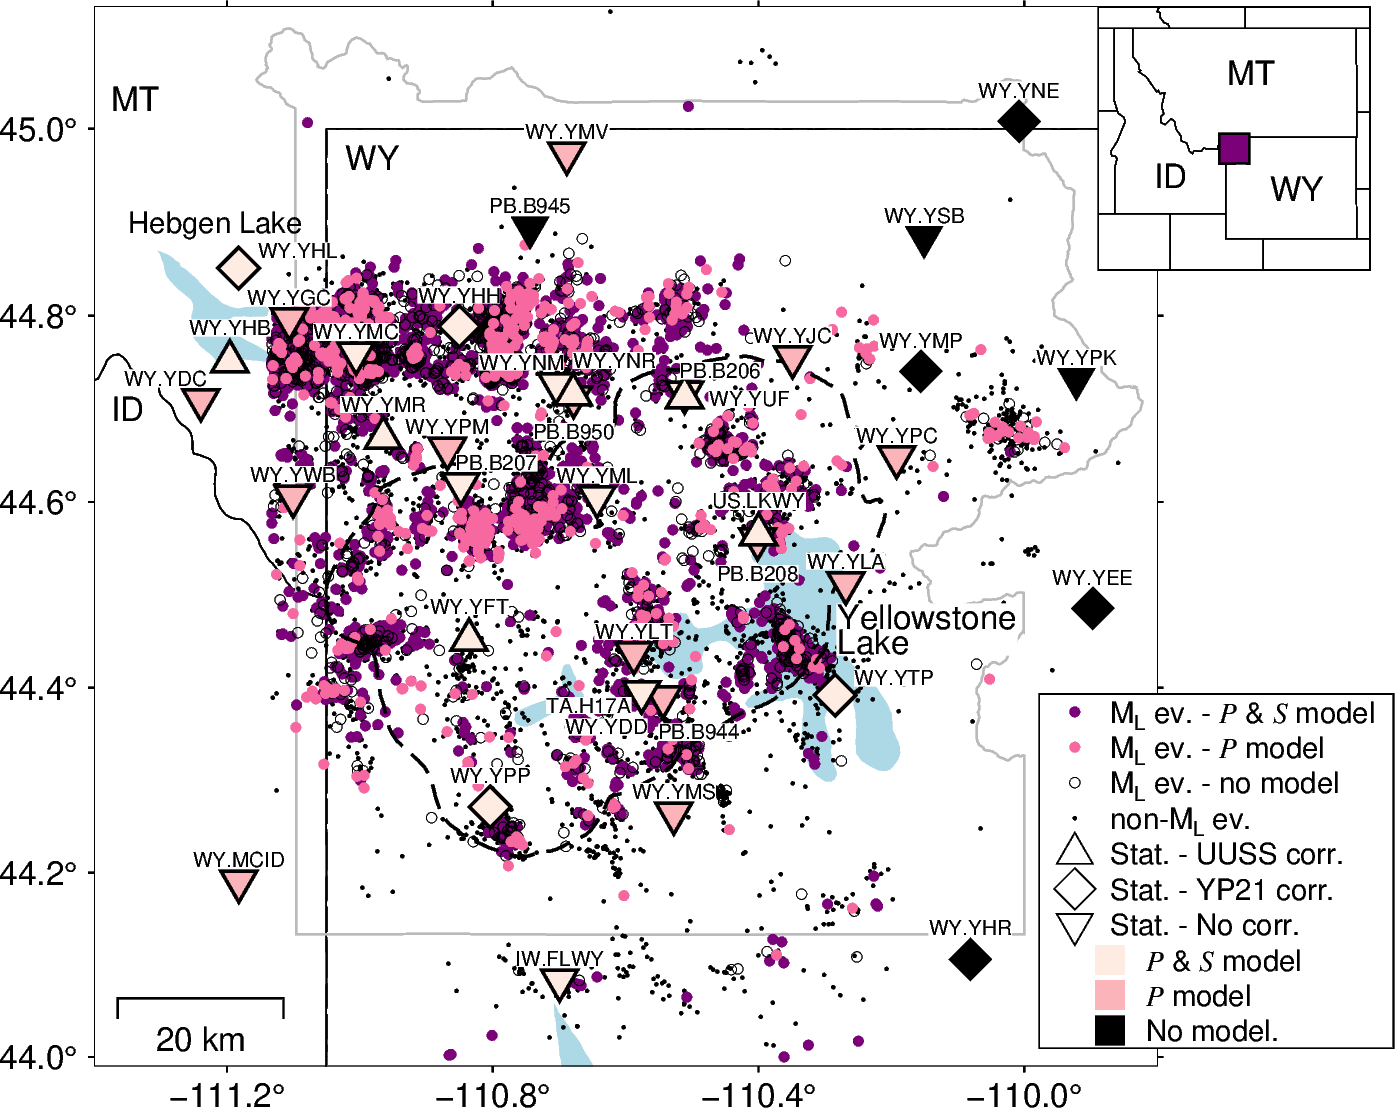

In [62]:
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP="ddd.x")
pygmt.config(FONT="8p")

STUDYREG = np.array([-111.40, -109.80, 43.99, 45.13])
projection = f"M5.4/9"


with pygmt.config(MAP_FRAME_TYPE="plain", MAP_FRAME_PEN="0.15p", MAP_TICK_LENGTH_PRIMARY="0.05c", 
                 FONT_TITLE="5p"):
    fig.coast(region=STUDYREG, projection=projection, water="lightblue", borders="2/0.3p")

    fig.basemap(region=STUDYREG, projection=projection, frame=["SenW+t", "xa0.4", "ya0.2"], 
               map_scale="jBL+w20k+o0.2c/0.4c")

#
# Plot utahnet boundaries
#
# fig.plot(data=caldera, pen='0.75p,#bababa,-')
fig.plot(data=ys_border, pen='0.5p,#bababa')
#fig.plot(data=uuss_auth_box, pen='0.5p,gray,-')

#
# Plot events
#
fig.plot(data=ev_cat_filt[ev_cat_filt['magnitude_type'] != 'l'][['event_lon', 'event_lat']], style='c1.0p', fill='black', label='not local')
fig.plot(data=ps_merge_ev[ps_merge_ev['_merge']=='both'][["source_longitude_p", "source_latitude_p"]], style="c2.5p", fill="#7a0177", label='local P and S')
fig.plot(data=ev_cat_filt[ev_cat_filt['magnitude_type'] == 'l'][~ev_cat_filt[ev_cat_filt['magnitude_type'] == 'l']['evid'].isin(ps_merge_ev['event_identifier'])][['event_lon', 'event_lat']],
         style='c2.5p', 
         pen='0.1p,black',
         label='local')
fig.plot(data=ps_merge_ev[ps_merge_ev['_merge']=='left_only'][["source_longitude_p", "source_latitude_p"]], style="c2.5p", fill="#f768a1", label='local P')

##fig.plot(data=ps_merge_ev[ps_merge_ev['_merge']=='right_only'][["source_longitude_s", "source_latitude_s"]], style="c0.75p", fill="blue")

#
# State labels, title, etc
#
fig.plot(data=caldera, pen='0.75p,black,-')#bababa

fig.text(x=-111.375, y=45.0, text="MT", offset="0.0/0.25", justify="LM")
fig.text(x=-111.2, y=45.0, text="WY", offset="1.00/-0.25", justify="LM")
fig.text(x=-111.375, y=44.7, text="ID", justify="LM")

# fig.text(x=-111.25, y=44.88, text="Hebgen Lake", justify="CM", angle=-42, offset='-0.05c/-0.05c')
# fig.text(x=-110.2, y=44.40, text="Yellowstone Lake", justify="RM", angle=-73, offset='0.20c/-0.35c', fill='white')
fig.text(x=-111.2, y=44.9, text="Hebgen Lake", justify="CM", offset="-0.1/-0.00", font='7p,Helvetica')
with open('ysl.txt', 'w') as fp:
    fp.write('''\
> -110.15 44.45 6p 0.1i l
Yellowstone Lake
''')
fig.text(textfiles='ysl.txt', M=True, offset='0.02c/0.1c', fill='white', clearance='0.2p')

#
#Plot stations
#
t_size = 0.35
stat_sym = ['i', 't']
stat_ec = ['black', 'black']
for i in range(2):
    s_df = station_df[station_df['station'].isin(stats_with_corrections) == i]
    ps_m_df = ps_merge_stats[ps_merge_stats.station.isin(stats_with_corrections) == i]
    if i == 0:
        s_j_df = s_df[s_df['station'].isin(james_stat_corrections)]
        ps_j_m_df = ps_m_df[ps_m_df['station'].isin(james_stat_corrections)]
        s_df = s_df[~s_df['station'].isin(james_stat_corrections)]
        ps_m_df = ps_m_df[~ps_m_df['station'].isin(james_stat_corrections)]
        
        fig.plot(data=s_j_df[~s_j_df['station'].isin(p_stats.station)][['receiver_lon', 'receiver_lat']], style=f'd{t_size}c', fill='black', pen=f'0.3p,{stat_ec[i]}')
        if 'left_only' in ps_j_m_df['_merge'].unique():
            fig.plot(data=ps_j_m_df[ps_j_m_df['_merge']=='left_only'][['receiver_lon_p', 'receiver_lat_p']], style=f'd{t_size}c', fill='#fbb4b9', pen=f'0.75p,{stat_ec[i]}')
        fig.plot(data=ps_j_m_df[ps_j_m_df['_merge']=='both'][['receiver_lon_p', 'receiver_lat_p']], style=f'd{t_size}c', fill='#feebe2', pen=f'0.75p,{stat_ec[i]}')

    fig.plot(data=s_df[~s_df['station'].isin(p_stats.station)][['receiver_lon', 'receiver_lat']], style=f'{stat_sym[i]}{t_size}c', fill='black', pen=f'0.3p,{stat_ec[i]}')
    if 'left_only' in ps_m_df['_merge'].unique():
        fig.plot(data=ps_m_df[ps_m_df['_merge']=='left_only'][['receiver_lon_p', 'receiver_lat_p']], style=f'{stat_sym[i]}{t_size}c', fill='#fbb4b9', pen=f'0.75p,{stat_ec[i]}')
    fig.plot(data=ps_m_df[ps_m_df['_merge']=='both'][['receiver_lon_p', 'receiver_lat_p']], style=f'{stat_sym[i]}{t_size}c', fill='#feebe2', pen=f'0.75p,{stat_ec[i]}')

for i, stat_row in station_df.iterrows():
    ud_offset = 0.185
    lr_offset = 0.0
    stat = stat_row['station']
    if stat in ['YDC', 'YDD', 'YNM']:
        lr_offset += -0.3
    elif stat in ['B207', 'B206', 'B944']:
        lr_offset += 0.3
    elif stat in ['YHL', 'YTP']:
        lr_offset += 0.5
    elif stat in ['YUF']:
        lr_offset += 0.55
    elif stat in ['H17A']:
        lr_offset += -0.45
    elif stat in ['YNR']:
        lr_offset += 0.35

    if stat in ['YHL', 'YTP' ]:
        ud_offset += -0.04
    elif stat in ['YUF']:
        ud_offset += -0.2
    elif stat in ['H17A']:
        ud_offset += -0.3
    elif stat in ['B950', 'B208', 'B944', 'YDD']:
        ud_offset += -0.48
    elif stat in stats_with_corrections:
        ud_offset += 0.1
    elif stat in james_stat_corrections:
        ud_offset += 0.08

    fig.text(x=stat_row['receiver_lon'], 
             y=stat_row['receiver_lat'], 
             text=f"{stat_row['network']}.{stat}",
             font='5p,Helvetica',
             offset=f'{lr_offset}c/{ud_offset}c',
             fill="white", 
             clearance="0.2p")

#
# Plot map insert
#
with fig.inset(position="jTR+o-1.8c/0.0c+w2.3c/2.23c", box="+p0.3,black+gwhite"):
    fig.coast(
        region = STUDYREG + np.array([-6.5, 6.5, -4.25, 4.6]),
        projection = f"M5.4/9/?",
        borders = [1, 2]
    )
    with pygmt.config(MAP_FRAME_TYPE="plain"):
        fig.basemap(frame=["nsew"])
        
    fig.plot(data=[[STUDYREG[0], STUDYREG[2], STUDYREG[1], STUDYREG[3]]], style="r+s", fill="#7a0177", pen="0.5p,black")

    fig.text(
        x = -107.25, 
        y = 43,
        text = "WY",
    )
    fig.text(
        x = -114, 
        y = 43.5, 
        text = "ID", 
    )
    fig.text(
        x = -109.7, 
        y = 47.4, 
        text = "MT", 
    )

#
# Plot legend
#
with fig.inset(position="jBR+o-2.0/0.15", 
               box="+p0.3,black+gwhite",
               region=[-1, 1, -1, 1], projection='X3c'):

        text_x = -0.6
        sym_x = -0.8
        # Dark, filled circle
        y = 0.9
        fig.plot(data=[[sym_x, y]], 
                style="c2.5p", 
                fill="#7a0177")
        fig.text(x=text_x, y=y, text='M@-L@- ev. - @%Times-Italic%P@%% & @%Times-Italic%S@%% model', justify='ML', font='7p,Helvetica')

        # # Light, filled circle
        y -= 0.2
        fig.plot(data=[[sym_x, y]],
                style="c2.5p",
                fill="#f768a1")
        fig.text(x=text_x, y=y, text='M@-L@- ev. - @%Times-Italic%P@%% model', justify='ML', font='7p,Helvetica')

        # # Open circle
        y -= 0.2
        fig.plot(data=[[sym_x, y]],
                style='c2.5p', 
                pen='0.1p,black')  
        fig.text(x=text_x, y=y, text='M@-L@- ev. - no model', justify='ML', font='7p,Helvetica')

        # # dark point
        y -= 0.2
        fig.plot(data=[[sym_x, y]],
                style='c1.0p', 
                fill='black')
        fig.text(x=text_x, y=y, text='non-M@-L@- ev.', justify='ML', font='7p,Helvetica')

        # Triangle
        y -= 0.2
        fig.plot(data=[[sym_x, y]], 
                style=f't{t_size}c', 
                fill='white', 
                pen=f'0.3p,black') 
        fig.text(x=text_x, y=y, text='Stat. - UUSS corr.', justify='ML', font='7p,Helvetica')
      
        # Diamond
        y -= 0.2
        fig.plot(data=[[sym_x, y]], 
                style=f'd{t_size}c', 
                fill='white', 
                pen=f'0.3p,black')  
        fig.text(x=text_x, y=y, text='Stat. - YP21 corr.', justify='ML', font='7p,Helvetica')
            
        # Inverted Triangle 
        y -= 0.2
        fig.plot(data=[[sym_x, y]], 
                style=f'i{t_size}c', 
                fill='white', 
                pen=f'0.3p,black')   
        fig.text(x=text_x, y=y, text='Stat. - No corr.', justify='ML', font='7p,Helvetica')

        # Mid fill
        # P & S fill='#feebe2'
        y -= 0.2
        sym_x += 0.2
        text_x += 0.2
        fig.plot(data=[[sym_x, y]], 
                style=f's{t_size}c', 
                fill='#feebe2')     
        fig.text(x=text_x, y=y, text='@%Times-Italic%P@%% & @%Times-Italic%S@%% model', justify='ML', font='7p,Helvetica')

        # Light fill
        # Just P fill='#fbb4b9'
        y -= 0.2
        fig.plot(data=[[sym_x, y]], 
                style=f's{t_size}c', 
                fill='#fbb4b9')   
        fig.text(x=text_x, y=y, text='@%Times-Italic%P@%% model', justify='ML', font='7p,Helvetica')
  
        # Black fill
        y -= 0.2
        fig.plot(data=[[sym_x, y]], 
                style=f's{t_size}c', 
                fill='black')  
        fig.text(x=text_x, y=y, text='No model.', justify='ML', font='7p,Helvetica')
         
fig.show()
fig.savefig("../figures/ys_map.png", dpi=300)